In [1]:
import numpy as np
import awkward as ak
from distributed import Client
import matplotlib.pyplot as plt
import mplhep
import pandas as pd
import coffea.util
import re
import os
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from collections import defaultdict
import uproot

from coffea import processor
import hist
from hist import Hist
from coffea.analysis_tools import PackedSelection

plt.style.use(mplhep.style.CMS)

In [164]:
fname = "root://eosuser.cern.ch//eos/user/a/adlintul/ScoutingPFRun3/Run2022F/230114_155334/0000/nanoaod_109.root"

events = NanoEventsFactory.from_root(
    fname,
    treepath="Events",
    schemaclass=ScoutingNanoAODSchema,
).events()

In [120]:
def PackedSelection_any(self, *names):
    consider = 0
    for name in names:
        idx = self._names.index(name)
        consider |= 1 << idx
    return (self._data & consider) != 0

def JetID(jet):
    
    return (
        (jet.neHEF < 0.9) 
        & (jet.neEmEF < 0.9)
        & (jet.muEmEF < 0.8)
        & (jet.chHEF > 0.01)
        & (jet.nCh > 0)
        & (jet.chEmEF < 0.8)
    )

class TriggerProcessor(processor.ProcessorABC):
    def __init__(self, year="2022F"):
        self._year = year
        self._sigtriggers = {
            '2022F': [
                'SingleJet180',
                'HTT360er',
            ]
        }
        self._reftriggers = {
            '2022F': [
                'SingleIsoEG30er2p1'
            ]
        }
        
    @property
    def accumulator(self):
        return {
                "nevents": defaultdict(float),
                "trigger": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset name", growth=True
                            ).StrCategory(
                                [], name="era", label="Era", growth=True
                            ).StrCategory(
                                [], name="trigger", label="Trigger name", growth=True
                            ).Reg(
                                100, 0, 1000, name="pt", label="Leading jet $p_T$"
                            ).Reg(
                                100, 0, 300, name="mass", label="Leading jet mass"
                            ).Reg(
                                100, 0, 1, name="btag", label="Leading jet ParticleNet Hbb vs QCD score"
                            ).Double()
                        ),

                }

    def process(self, events):
        
        output = self.accumulator
        
        isRealData = not "genWeight" in events.fields
        if isRealData:
            era = "Data"
        else:
            era = "MC"
        dataset = events.metadata['dataset']
        output["nevents"][dataset] += len(events)
        
        trigger = PackedSelection()
        trigger_names = self._sigtriggers["2022F"]
        for tname in trigger_names:
            if tname in events.L1.fields:
                trigger.add(tname, events.L1[tname])
            else:
                trigger.add(tname, np.zeros(len(events), dtype=bool))

        reftrigger = np.zeros(len(events), dtype=bool)
        for tname in self._reftriggers[self._year]:
            if tname in events.L1.fields:
                reftrigger |= ak.to_numpy(events.L1[tname])
                
        muons = events.ScoutingMuon[
            (events.ScoutingMuon.pt > 25)
            & (abs(events.ScoutingMuon.eta) < 2.4)
        ]
        
        jet = ak.firsts(events.ScoutingFatJet[
            (events.ScoutingFatJet.pt > 100)
            & (abs(events.ScoutingFatJet.eta) < 2.5)
            & (JetID(events.ScoutingFatJet))
            #& ak.all(events.Jet.metric_table(muons) > 0.4, axis=-1)  # default metric: delta_r
        ])
        
        jet["pn_Hbb"] = jet.particleNet_prob_Hbb / (jet.particleNet_prob_Hbb + jet.particleNet_prob_QCD)
        
        jet_exists = ~ak.is_none(jet) & reftrigger
        #print("Jet exists: ", ak.sum(jet_exists))

        output["trigger"].fill(
            dataset = dataset,
            era=era,
            pt = jet[jet_exists].pt,
            mass = jet[jet_exists].mass,
            trigger="none",
            btag = jet[jet_exists].pn_Hbb,
        )
        
        cut = jet_exists & PackedSelection_any(trigger, *set(trigger_names))
        
        output["trigger"].fill(
            dataset=dataset,
            era=era,
            pt=jet[cut].pt,
            mass = jet[cut].mass,
            trigger="any",
            btag = jet[cut].pn_Hbb,
        )
        
        for tname in trigger_names:
            cut = jet_exists & trigger.all(tname)
            output["trigger"].fill(
                dataset=dataset,
                era=era,
                pt=jet[cut].pt,
                mass=jet[cut].mass,
                trigger=tname,
                btag = jet[cut].pn_Hbb,
            )
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [106]:
import json

fileset = {}

with open("../input/Data_Run2Summer22.json") as fin:
    fileset = json.load(fin)
    
with open("../input/QCD_Run2Summer22.json") as fin:
    fileset.update(json.load(fin))

In [118]:
fileset = {
    "data" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/ScoutingPFRun3/Run2022F/230114_155334/0000/nanoaod_109.root"
    ],
    "mc" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/QCD_PT-120to170_TuneCP5_13p6TeV_pythia8/Run3Summer22/230114_094511/0000/nanoaod_10.root"
    ]
}

In [116]:
# run the processor

from coffea import processor, util

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema = ScoutingNanoAODSchema,
    maxchunks = 10,
)

out = futures_run(
    fileset,
    "Events",
    processor_instance=TriggerProcessor()
)

Output()

Task was destroyed but it is pending!
task: <Task pending name='Task-376896' coro=<ProgressBar.listen() running at /opt/conda/lib/python3.8/site-packages/distributed/diagnostics/progressbar.py:75> wait_for=<Future cancelled> cb=[IOLoop.add_future.<locals>.<lambda>() at /opt/conda/lib/python3.8/site-packages/tornado/ioloop.py:687]>
Task was destroyed but it is pending!
task: <Task pending name='Task-376896' coro=<ProgressBar.listen() running at /opt/conda/lib/python3.8/site-packages/distributed/diagnostics/progressbar.py:75> wait_for=<Future cancelled> cb=[IOLoop.add_future.<locals>.<lambda>() at /opt/conda/lib/python3.8/site-packages/tornado/ioloop.py:687]>
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


Task was destroyed but it is pending!
task: <Task pending name='Task-376896' coro=<ProgressBar.listen() running at 
/opt/conda/lib/python3.8/site-packages/distributed/diagnostics/progressbar.py:75> wait_for=<Future cancelled> 
cb=[IOLoop.add_future.<locals>.<lambda>() at /opt/conda/lib/python3.8/site-packages/tornado/ioloop.py:687]>

Process ForkProcess-9:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/conda/lib/python3.8/multiprocessing/queues.py", line 97, in get
    res = self._recv_bytes()
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt

KeyboardInterrupt



In [104]:
out['trigger']

Hist(
  StrCategory(['mc', 'data'], growth=True, name='dataset', label='Dataset name'),
  StrCategory(['none', 'any', 'SingleJet180', 'HTT360er'], growth=True, name='trigger', label='Trigger name'),
  Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
  Regular(100, 0, 300, name='mass', label='Leading jet mass'),
  storage=Double()) # Sum: 132718.0 (132722.0 with flow)

In [121]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

from dask.distributed import performance_report
from dask_jobqueue import HTCondorCluster, SLURMCluster

env_extra = [
    f"export PYTHONPATH=$PYTHONPATH:{os.getcwd()}",
]

cluster = LPCCondorCluster(
    ship_env=True,
)

cluster.adapt(minimum=1, maximum=100)
client = Client(cluster)

print("Waiting for at least one worker...")
client.wait_for_workers(1)

uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource

output = processor.run_uproot_job(
            fileset,
            "Events",
            processor_instance=TriggerProcessor(),
            executor=processor.dask_executor,
            executor_args={
                "schema": ScoutingNanoAODSchema,
                "savemetrics": True,
                "retries": 3,
                "client": client,
            },
            chunksize=10000,
            #maxchunks=args.max,
        )

/opt/conda/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41753 instead
  warnings.warn(


Waiting for at least one worker...


In [122]:
output[0]

{'nevents': defaultdict(float, {'data': 700990.0, 'mc': 1410.0}),
 'trigger': Hist(
   StrCategory(['data', 'mc'], growth=True, name='dataset', label='Dataset name'),
   StrCategory(['Data', 'MC'], growth=True, name='era', label='Era'),
   StrCategory(['none', 'any', 'SingleJet180', 'HTT360er'], growth=True, name='trigger', label='Trigger name'),
   Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
   Regular(100, 0, 300, name='mass', label='Leading jet mass'),
   Regular(100, 0, 1, name='btag', label='Leading jet ParticleNet Hbb vs QCD score'),
   storage=Double()) # Sum: 733.0 (132722.0 with flow)}

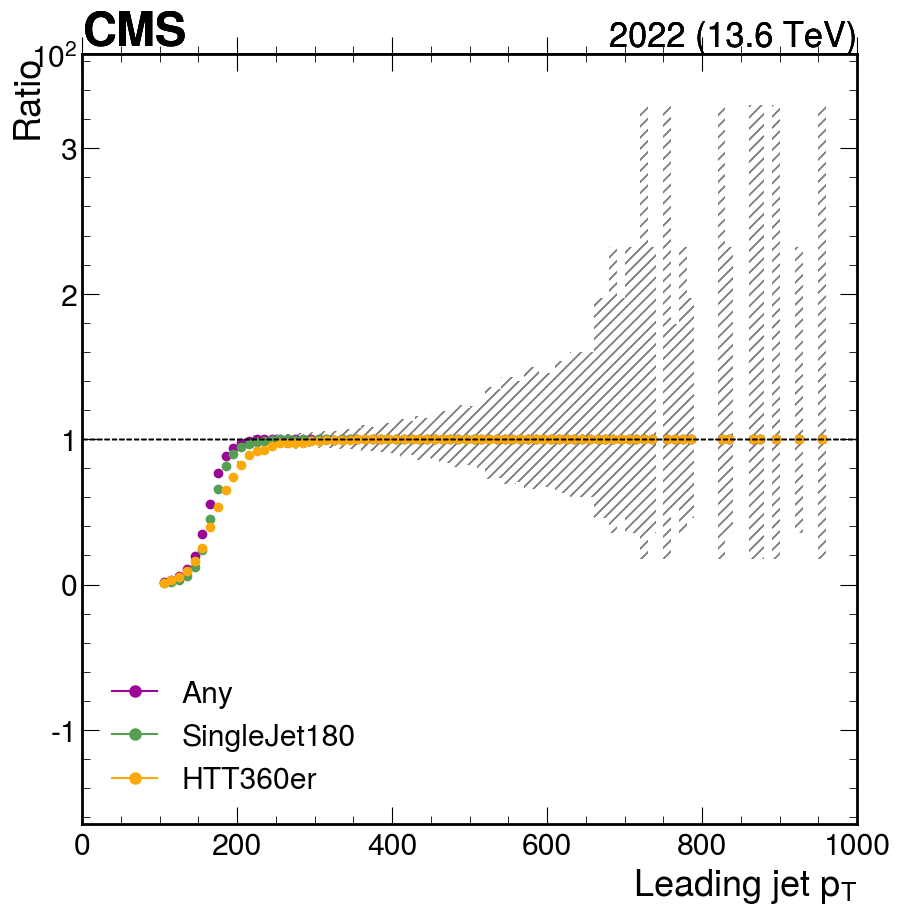

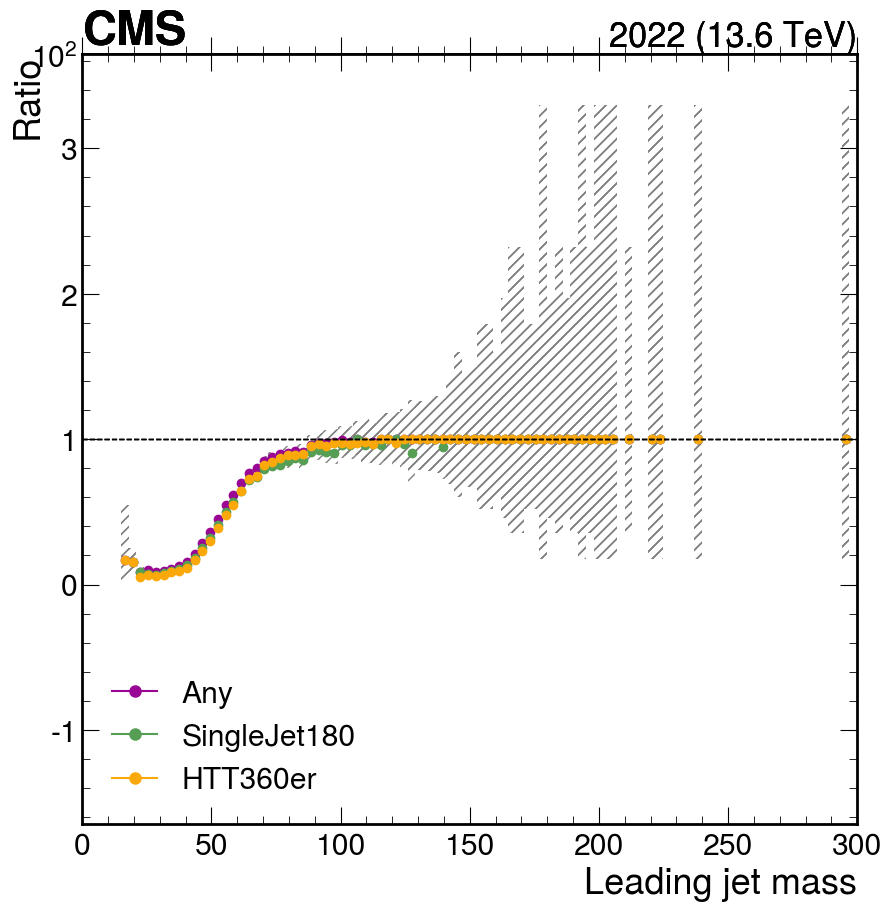

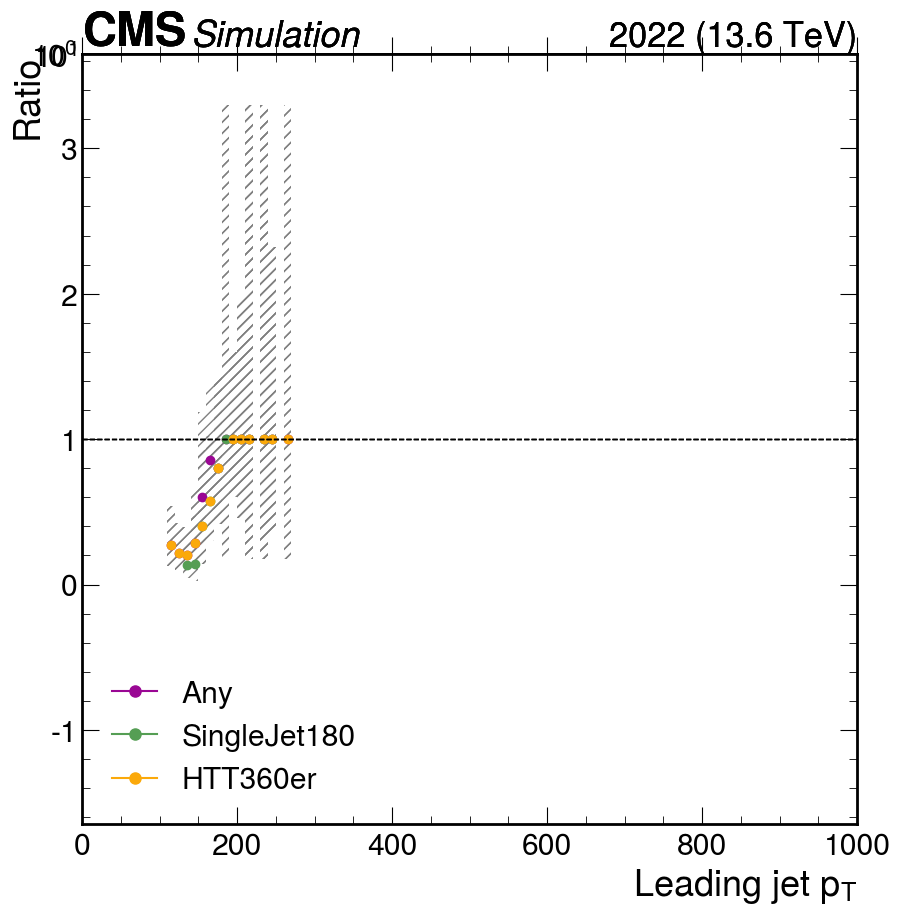

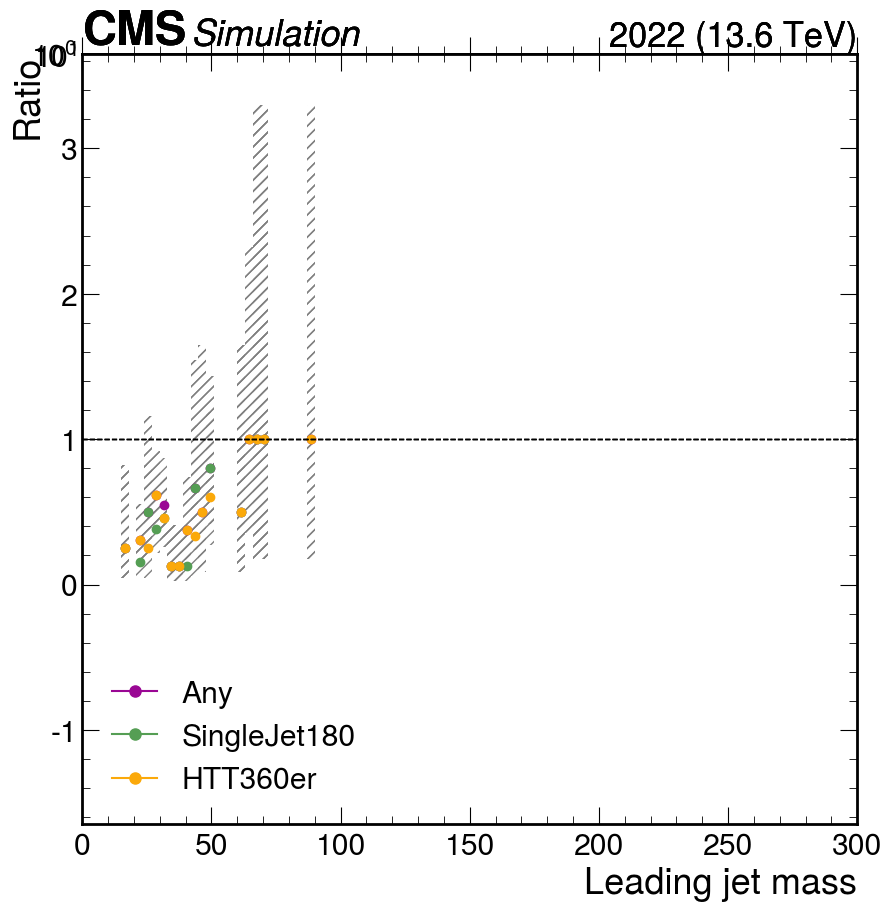

In [129]:
out = output[0]

labels = {
    'any' : '#9A0794', 
    'SingleJet180' : '#559E54', 
    'HTT360er' : '#FBA90A',
}

for era in ["Data", "MC"]:
    for var in ["pt", "mass"]:
        ptproj = (
            out["trigger"]
            .project("era", var, "trigger")[hist.loc(era), :, :]
        )

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [0, 3]})
        fig.subplots_adjust(hspace=0)
        handles = []
        for tname in labels.keys():

            denom = ptproj[:, hist.loc("none")]
            num = ptproj[:, hist.loc(tname)]
            main_ax_artists, sublot_ax_arists = num.plot_ratio(
                denom,
                rp_ylabel=r"Ratio",
                rp_num_label=tname,
                rp_denom_label=f"Reference trigger and\n{tname}",
                rp_uncert_draw_type="bar",
                ax_dict={"main_ax" : ax1, "ratio_ax" : ax2}
            )

            sublot_ax_arists.dots.set_color(labels[tname])

            ax1.set_xlabel('')
            ax1.set_ylabel('')
            ax1.set_yscale('log')
            #ax1.set_xlim(100,400)
            #ax2.set_ylim(-0.1,1.5)
            mplhep.cms.label(ax=ax1, data=True if era == "Data" else False, year="2022", rlabel="2022 (13.6 TeV)")

            from matplotlib.lines import Line2D
            dot = Line2D([0], [0], marker='o', color=labels[tname], label=tname if tname != "any" else "Any", markersize=8) 
            handles.extend([dot])
            plt.legend(handles=handles)


    #plt.savefig("ak8_data_pt_zoom.png")

In [47]:
sublot_ax_arists.dots

In [242]:
from coffea.hist import clopper_pearson_interval

num = (
    out["trigger"]
    .project("pt", "mass", "trigger", "dataset")[::hist.rebin(2), ::hist.rebin(2), hist.loc("any"), hist.loc('Run2022F')]
)

denom = (
    out["trigger"]
    .project("pt", "mass", "trigger", "dataset")[::hist.rebin(2), ::hist.rebin(2), hist.loc("none"), hist.loc('Run2022F')]
)

rdata = (
    num.view() 
    / np.maximum(1, denom.view())
)

rdata_unc = clopper_pearson_interval(
    num.view(),
    denom.view(),
)

In [243]:
num = (
    out["trigger"]
    .project("pt", "mass", "trigger", "dataset")[::hist.rebin(2), ::hist.rebin(2), hist.loc("any"), [hist.loc('QCD_PT-120to170'), hist.loc('QCD_PT-300to470'), hist.loc('QCD_PT-470to600'), hist.loc('QCD_PT-600toInf')]]
)[{"dataset" : sum}]

denom = (
    out["trigger"]
    .project("pt", "mass", "trigger", "dataset")[::hist.rebin(2), ::hist.rebin(2), hist.loc("any"), [hist.loc('QCD_PT-120to170'), hist.loc('QCD_PT-300to470'), hist.loc('QCD_PT-470to600'), hist.loc('QCD_PT-600toInf')]]
)[{"dataset" : sum}]

rmc = (
    num.view() 
    / np.maximum(1, denom.view())
)

rmc_unc = clopper_pearson_interval(
    num.view(),
    denom.view(),
)

In [244]:
scalefactor = rdata / np.where(rmc == 0, 1., rmc)
scalefactor_up = rdata_unc[1] / np.where(rmc_unc[0] == 0, np.inf, rmc_unc[0])
scalefactor_dn = rdata_unc[0] / np.where(rmc_unc[1] == 0, 1., rmc_unc[1])
x = num.copy()
y = x.copy()
x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor
y[...] = scalefactor

/tmp/ipykernel_22394/1257522860.py:6: RuntimeWarning: divide by zero encountered in divide
  x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor
/tmp/ipykernel_22394/1257522860.py:6: RuntimeWarning: invalid value encountered in divide
  x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor


(exptext: Custom Text(0.0, 1, 'CMS'), expsuffix: Custom Text(0.0, 1.005, ''))

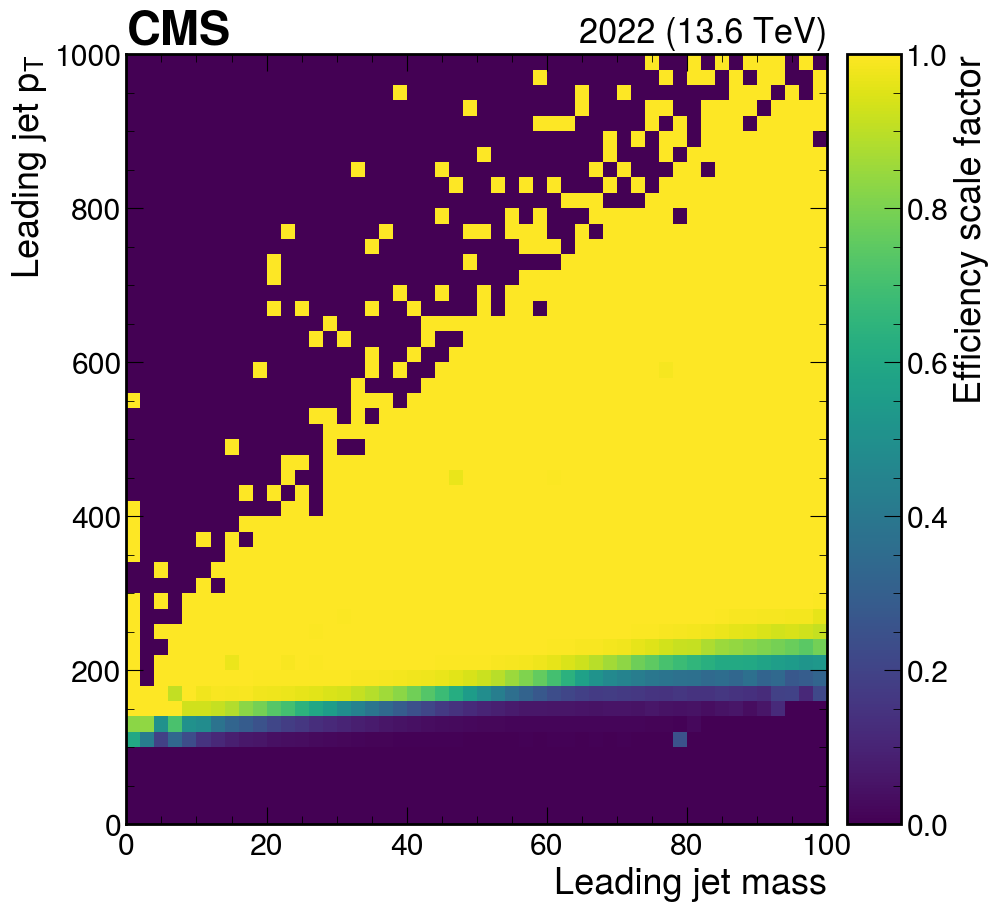

In [245]:
fig, ax = plt.subplots()

artist = mplhep.hist2dplot(y.project(1, 0), ax=ax, cmin=0, cmax=2)
artist.cbar.set_label("Efficiency scale factor")
mplhep.cms.label(ax=ax, data=True, year="2022", rlabel="2022 (13.6 TeV)")

(exptext: Custom Text(0.0, 1, 'CMS'), expsuffix: Custom Text(0.0, 1.005, ''))

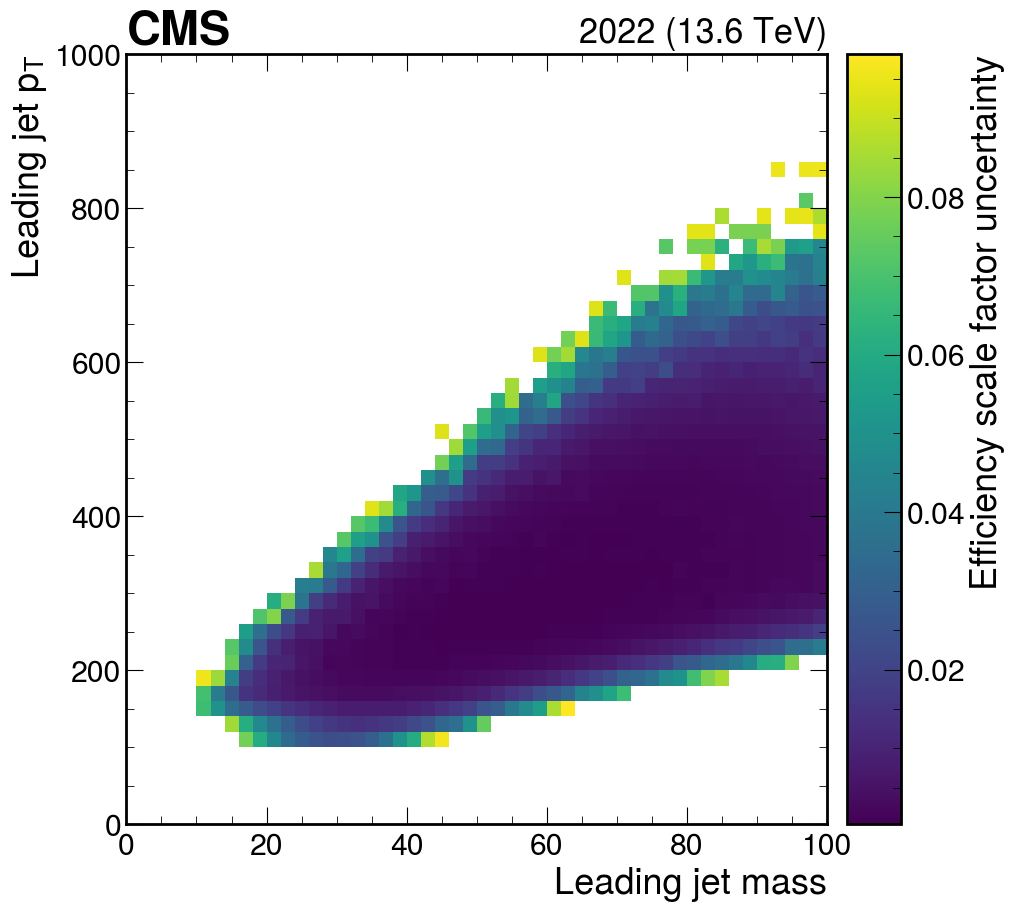

In [246]:
fig, ax = plt.subplots()

artist = mplhep.hist2dplot(x.project(1, 0), ax=ax, cmin=0, cmax=0.1)
artist.cbar.set_label("Efficiency scale factor uncertainty")
mplhep.cms.label(ax=ax, data=True, year="2022", rlabel="2022 (13.6 TeV)")